In [1]:
print(__doc__)

import scipy.stats as scp_stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.special import expit

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn import metrics


import missingno as msno
import seaborn as sns

# pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.1f}".format
df = pd.read_csv("/content/drive/MyDrive/ML_data/all_training.csv", sep=',')


Automatically created module for IPython interactive environment


In [2]:
#Using robust scaling as normalization method

# Column selection
df_features = df.iloc[:,np.r_[3,5:34]].copy()

# create a scaler object
scaler = RobustScaler()

# fit and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
n_samples, n_features = df_features.shape

# How many nan values are there?
df_normalized.isna().sum()

CA       93
CREA     74
ALP     474
GGT     436
GLU      98
AST      98
ALT      96
LDH     303
PCR      97
KAL      80
NAT      73
UREA    676
WBC      63
RBC      63
HGB      63
HCT      63
MCV      63
MCH      63
MCHC     63
PLT1     63
NE      362
LY      362
MO      362
EO      362
BA      362
NET     362
LYT     362
MOT     362
EOT     362
BAT     362
dtype: int64

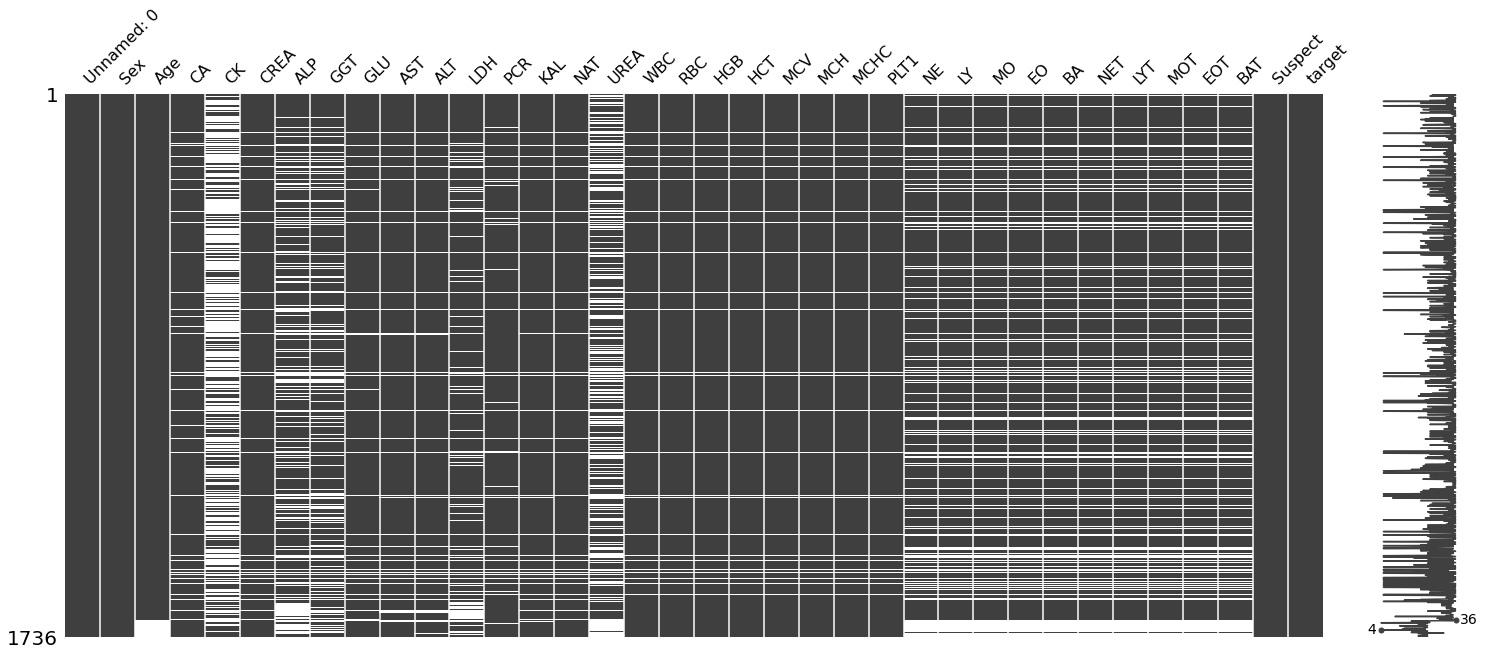

In [ ]:
%matplotlib inline
msno.matrix(df)
# msno.matrix(df_normalized)
# msno.heatmap(df_normalized)

In [3]:
# define row and column index
col = df_normalized.columns
row = [i for i in range(df_normalized.shape[0])]

# define imputer
imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

# fit on the dataset
imputer.fit(df_normalized)

# transform the dataset
df_normalized_imputed = imputer.transform(df_normalized)

# convert back to pandas dataframe and rename back to df_normalized
df_normalized = pd.DataFrame(data=df_normalized_imputed, index=row, columns=col)

# how many values does the imputation fix?
df_normalized.isna().sum()

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


CA      0
CREA    0
ALP     0
GGT     0
GLU     0
AST     0
ALT     0
LDH     0
PCR     0
KAL     0
NAT     0
UREA    0
WBC     0
RBC     0
HGB     0
HCT     0
MCV     0
MCH     0
MCHC    0
PLT1    0
NE      0
LY      0
MO      0
EO      0
BA      0
NET     0
LYT     0
MOT     0
EOT     0
BAT     0
dtype: int64

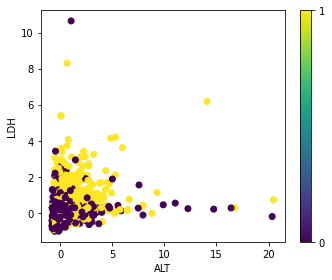

In [ ]:
# The indices of the features that we are plotting
x_index = 4
y_index = 5

# this formatter will label the colorbar with the correct target names
formatter = plt.FuncFormatter(lambda i, *args: df.target.unique()[int(i)])

plt.figure(figsize=(5, 4))
plt.scatter(df_normalized.iloc[:, x_index], df_normalized.iloc[:, y_index], c=df.target)
plt.colorbar(ticks=[0, 1], format=formatter)
plt.xlabel(df_normalized.columns[x_index])
plt.ylabel(df_normalized.columns[y_index])

plt.tight_layout()
plt.show()

(array([920.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 816.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

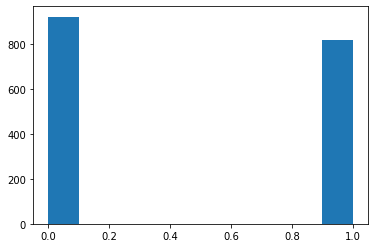

In [ ]:
# Plotting histogram
plt.hist(df.target)  

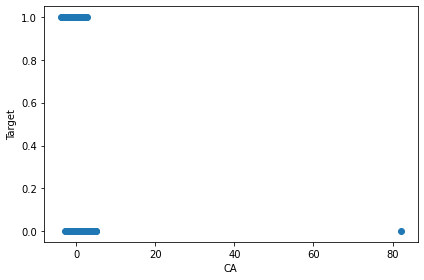

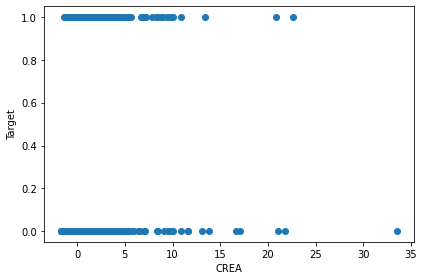

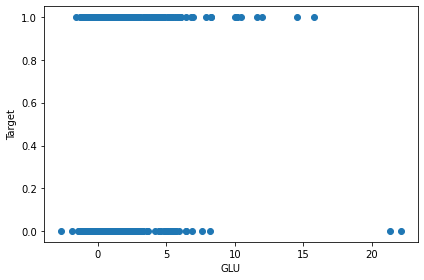

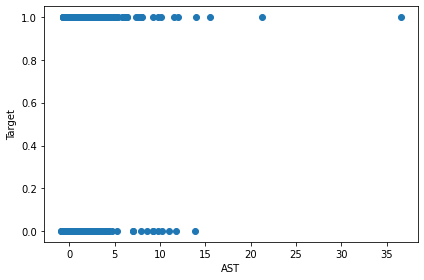

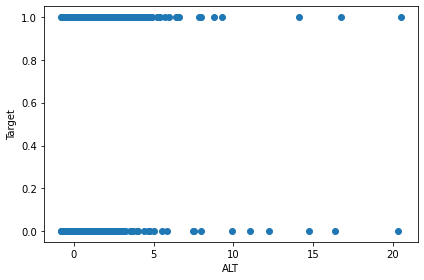

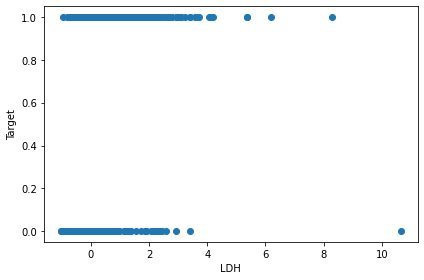

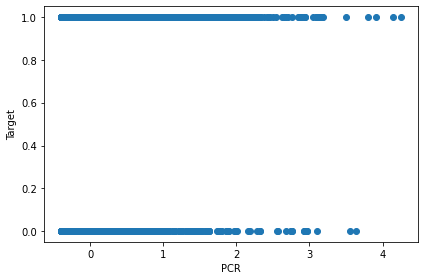

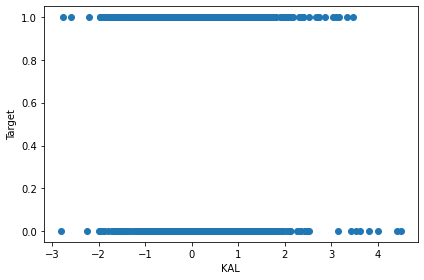

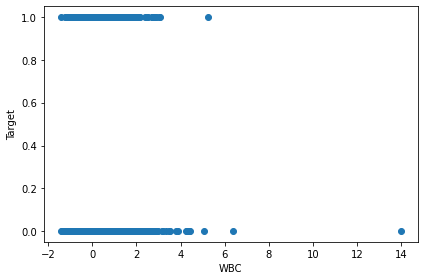

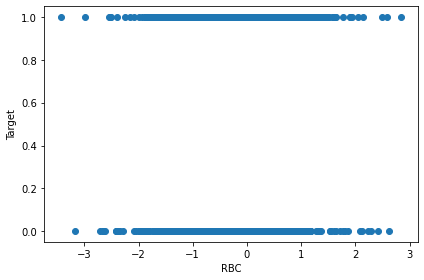

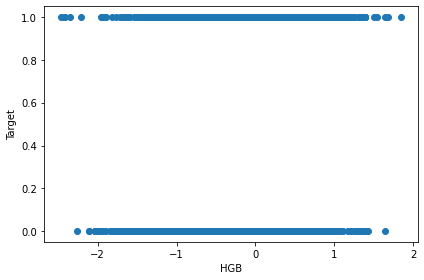

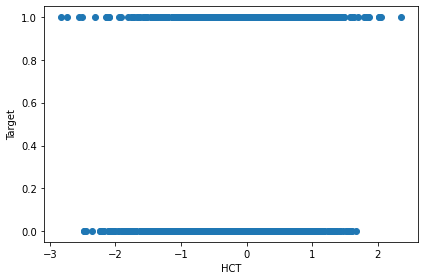

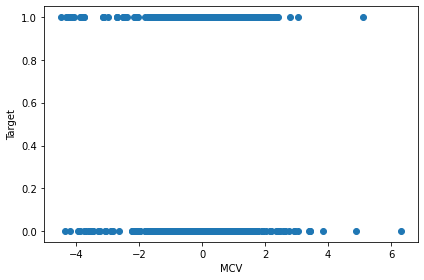

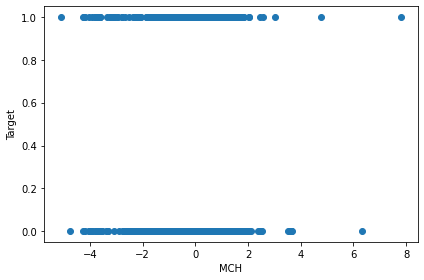

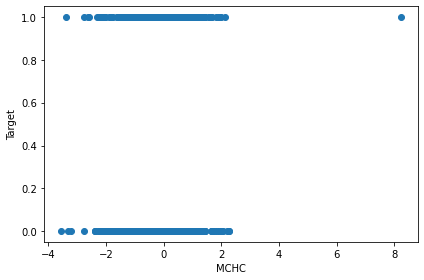

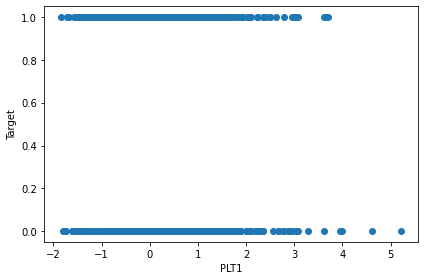

In [ ]:
# Plotting target dist for each features
for index, feature_name in enumerate(df_normalized.columns):
    plt.figure()
    plt.scatter(df_normalized.iloc[:, index], df.target)
    plt.xlabel(df_normalized.columns[index])
    plt.ylabel("Target")
    plt.tight_layout()
    plt.show()

In [4]:
# GBDC regression

# Data preparation
X = df_normalized
y = df.target

#Recursive feature elimination

gbcreg = GradientBoostingClassifier()
# Define the method
rfe = RFE(estimator=gbcreg, n_features_to_select=10)
# Fit the model
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
# print(rfe.ranking_)

# Drop columns that failed RFE test
col = df_normalized.columns[rfe.support_]
X = X[col]
X = X.to_numpy()

# Cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# The line is disabled since single column has not been specified 
#X = X[:, np.newaxis]

[ True False False False False  True False  True  True False False False
  True  True False False False False False False False False False  True
 False  True False False  True  True]


In [5]:
# Create Decision Tree classifer object
gbc_skmodel = GradientBoostingClassifier(n_estimators=100)
# Train Decision Tree Classifer
res = gbc_skmodel.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = res.predict(X_test)
# Model Accuracy: How often is the classifier correct?
print(metrics.accuracy_score(y_test, y_pred))

0.7995391705069125


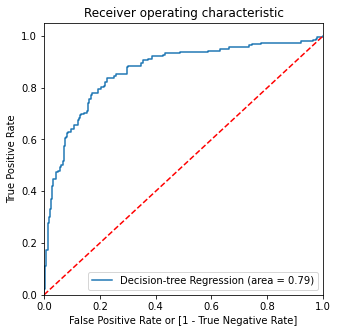

In [6]:
# ROC curve for sklearn decision tree regression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc_score = roc_auc_score(y_test, gbc_skmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gbc_skmodel.predict_proba(X_test)[:,1],drop_intermediate = False)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='Decision-tree Regression (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [7]:
# Feature importance
feature_imp = pd.Series(gbc_skmodel.feature_importances_,index=col).sort_values(ascending=False)
feature_imp

EOT   0.2
LDH   0.2
CA    0.1
WBC   0.1
RBC   0.1
PCR   0.1
EO    0.1
AST   0.0
NET   0.0
BAT   0.0
dtype: float64

No handles with labels found to put in legend.


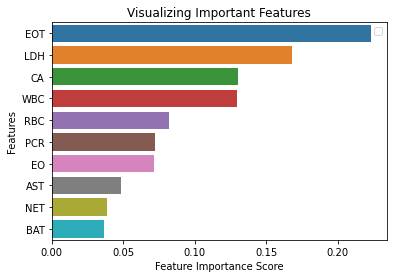

In [8]:
# Plotting feature importance

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
# #Remove features according to feature_importance

# # Split dataset into features and labels
# X=df_normalized[['CA','PCR','WBC']]  # Removed unimportant feature
# X = X.to_numpy()                                      
# # Split dataset into training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=0)

# # Create a Gaussian Classifier
# gbc_skmodel=GradientBoostingClassifier(n_estimators=100)
# # Train the random forest model
# gbc_skmodel.fit(X_train,y_train)

# # Predict the response for test dataset
# y_pred=gbc_skmodel.predict(X_test)
# # Model Accuracy: How often is the classifier correct?
# print(metrics.accuracy_score(y_test, y_pred))

In [9]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gbc_sklr = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_depth=6, random_state=0)
    gbc_sklr.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gbc_sklr.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gbc_sklr.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.925
Accuracy score (validation): 0.767
Learning rate:  0.075
Accuracy score (training): 0.935
Accuracy score (validation): 0.776
Learning rate:  0.1
Accuracy score (training): 0.942
Accuracy score (validation): 0.788
Learning rate:  0.25
Accuracy score (training): 0.982
Accuracy score (validation): 0.767
Learning rate:  0.5
Accuracy score (training): 0.992
Accuracy score (validation): 0.781
Learning rate:  0.75
Accuracy score (training): 0.994
Accuracy score (validation): 0.776
Learning rate:  1
Accuracy score (training): 0.994
Accuracy score (validation): 0.728
